# Reinforcement learning tutorial

https://www.geeksforgeeks.org/machine-learning/what-is-reinforcement-learning/

Maze example.

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

Step 1. Define problem (maze), start and goal.

In [38]:
# Zero values are safe paths. Ones are obstacles the agent must avoid.

maze = np.array([
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [0, 0, 0, 0, 1, 0, 0, 0, 0, 1],
    [1, 1, 1, 0, 1, 0, 1, 1, 0, 1],
    [1, 0, 0, 0, 0, 0, 1, 0, 0, 1],
    [1, 0, 1, 1, 1, 1, 1, 0, 1, 1],
    [1, 0, 1, 0, 0, 0, 0, 0, 1, 1],
    [1, 0, 1, 0, 1, 1, 1, 0, 1, 1],
    [1, 0, 1, 0, 1, 0, 0, 0, 1, 1],
    [1, 0, 1, 0, 1, 0, 1, 0, 0, 1],
    [1, 1, 1, 0, 1, 1, 1, 1, 0, 0]
])

# Where the agent starts
start = (0, 0)
# Where the agent has to reach
goal = (9, 9)

Step 2. Define RL Parameters and initialize Q-Table (Table of Rewards):

In [ ]:
# num_episodes: Number of times the agent will attempt to navigate the maze.
num_episodes = 5000

# alpha: Learning rate that controls how much new information overrides old information.
alpha = 0.1
# gamma: Discount factor giving more weight to immediate rewards.
gamma = 0.9
# epsilon: Probability of exploration vs exploitation; starts higher to explore more. 
epsilon = 0.5

#Rewards are set to penalize hitting obstacles, reward reaching the goal and slightly penalize each step to find shortest paths.
reward_fire = -10
reward_goal = 50
reward_step = -1

# actions define possible moves: left, right, up, down.
actions = [(0, -1), (0, 1), (-1, 0), (1, 0)]

# Q is the Q-Table initialized to zero; it stores expected rewards for each state-action pair.
Q = np.zeros(maze.shape + (len(actions),)) # Q.shape = [10,10,4]
print(Q.shape)

(10, 10, 4)


Step 3: Helper Function for Maze Validity and Action Selection

In [40]:
# is_valid ensures the agent can only move inside the maze and avoids obstacles.

def is_valid(pos):
    r, c = pos
    if r < 0 or r >= maze.shape[0]:
        return False
    if c < 0 or c >= maze.shape[1]:
        return False
    if maze[r, c] == 1:
        return False
    return True

# choose_action implements exploration (random action) vs exploitation (best learned action) strategy.
def choose_action(state):
    if np.random.random() < epsilon:
        # Exploration
        return np.random.randint(len(actions))
    else:
        # Exploitation (Best learned action)
        return np.argmax(Q[state])

Step 4: Train the Agent with Q-Learning Algorithm 

(SARSA algorithm)
![alt text](Q_Function.png "Q_Function")

Where:
- s: current state (agent's position in the maze)
- a: action taken in state s (e.g., move left, right, up, down)
- r: reward received after taking action a
- s': next state after performing action a
- α(alpha): learning rate controlling how much new information overrides old
- γ(gamma): discount factor for future rewards


In [41]:
rewards_all_episodes = []

# If the next stem hits a wall, the episode ends and starts again at the begining of the maze.
# If the step hits a wall, the reward is reward_fire, not reward_step + reward_fire
for episode in range(num_episodes):
    try_ended = False
    total_rewards = 0
    state = start
    while not try_ended:
        action_index = choose_action(state)
        action = actions[action_index]
        next_state = (state[0] + action[0], state[1] + action[1])

        if is_valid(next_state): 
            reward = reward_step

        elif next_state == goal:
            reward = reward_goal
            try_ended = True
        else:
            reward = reward_fire
            try_ended = True

        old_value = Q[state][action_index]
        next_max = np.max(Q[next_state]) if is_valid(next_state) else 0

        Q[state][action_index] = old_value + alpha*(reward + gamma*next_max - old_value)

        state = next_state
        total_rewards += reward
        
    # epsilon: Probability of exploration vs exploitation; starts higher to explore more. 
    # Then we lower it always beeing > 0
    global epsilon 
    epsilon = max(0.01, epsilon * 0.995)
    rewards_all_episodes.append(total_rewards)

Igual faltaría un backpropagation: si por un camino se consigue el objetivo, hacer backpropagation y sumar una recompensa positiva a cada paso.

In [42]:
print(Q[2])

[[ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [-9.98689979 -9.98689979 -9.98709779 -9.98691512]
 [ 0.          0.          0.          0.        ]
 [-9.9820299  -9.9820299  -9.98135716 -9.98159432]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [-9.97261073 -9.97261073 -9.97146259 -9.97144609]
 [ 0.          0.          0.          0.        ]]


Step 5: Extract the Optimal Path after Training

This function follows the highest Q-values at each state to extract the best path. It stops when the goal is reached or no valid next moves are available.

In [43]:
def get_optimal_path(Q, start, goal, actions, maze, max_steps=200):
    path = [start]
    state = start
    visited = set()

    for _ in range(max_steps):
        if state == goal:
            break
        visited.add(state)

        best_action = None
        best_value = -float('inf')

        # Para todas las acciones posibles
        for idx, move in enumerate(actions):
            next_state = (state[0] + move[0], state[1] + move[1])

            # Comprueba si la acción no se sale del laberinto, si no choca con ninguna pared y si no se ha visitado ya.
            if (0 <= next_state[0] < maze.shape[0] and
                0 <= next_state[1] < maze.shape[1] and
                maze[next_state] == 0 and
                    next_state not in visited):
                
                # Si cumple todo, mira a ver si es la mejor recompensa hasta ahora.
                if Q[state][idx] > best_value:
                    best_value = Q[state][idx]
                    # Guarda el índice de la mejor recompensa para cada paso.
                    best_action = idx

        # Si no ha encontrado mejor acción, ha topado con un punto muerto
        if best_action is None:
            break
        
        # Escoge en cada paso la acción que cumple las restricciones y mejor recompensa tiene
        move = actions[best_action]
        state = (state[0] + move[0], state[1] + move[1])
        path.append(state)

    return path


optimal_path = get_optimal_path(Q, start, goal, actions, maze)

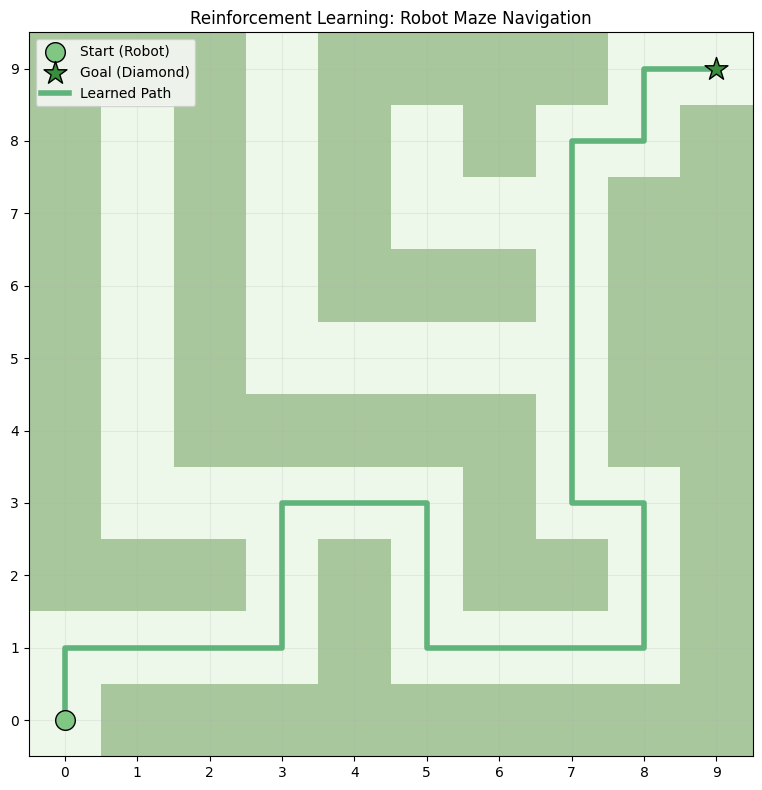

In [44]:
def plot_maze_with_path(path):
    cmap = ListedColormap(['#eef8ea', '#a8c79c'])

    plt.figure(figsize=(8, 8))
    plt.imshow(maze, cmap=cmap)

    plt.scatter(start[1], start[0], marker='o', color='#81c784', edgecolors='black',
                s=200, label='Start (Robot)', zorder=5)
    plt.scatter(goal[1], goal[0], marker='*', color='#388e3c', edgecolors='black',
                s=300, label='Goal (Diamond)', zorder=5)

    rows, cols = zip(*path)
    plt.plot(cols, rows, color='#60b37a', linewidth=4,
             label='Learned Path', zorder=4)

    plt.title('Reinforcement Learning: Robot Maze Navigation')
    plt.gca().invert_yaxis()
    plt.xticks(range(maze.shape[1]))
    plt.yticks(range(maze.shape[0]))
    plt.grid(True, alpha=0.2)
    plt.legend()
    plt.tight_layout()
    plt.show()


plot_maze_with_path(optimal_path)

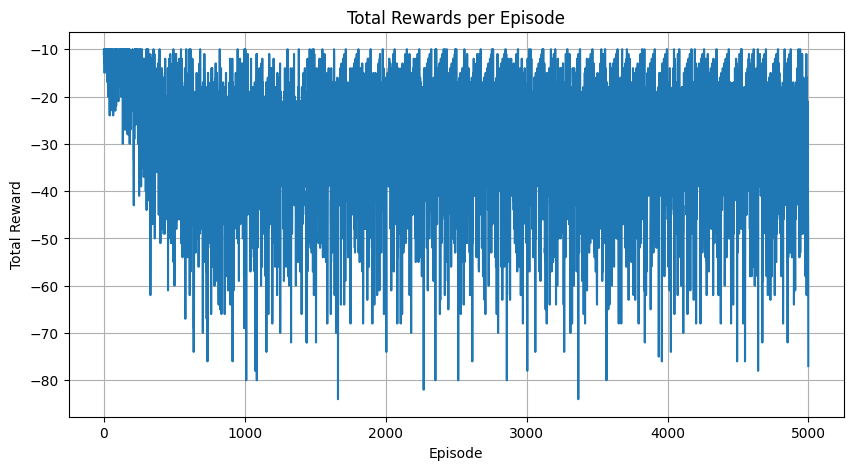

In [45]:
def plot_rewards(rewards):
    plt.figure(figsize=(10, 5))
    plt.plot(rewards)
    plt.title('Total Rewards per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.grid(True)
    plt.show()

plot_rewards(rewards_all_episodes)